# Imports

In [258]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Extracting and storing data


#### Extracting the HTML data and store it in the code2convos dictionary.

In [259]:
data_path = "./dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts


100%|██████████| 127/127 [00:20<00:00,  6.06it/s]


#### Creating a seperate object for user prompts

In [260]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [261]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

#### Creating an empty question list

In [262]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing
Understanding the Dataset:
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

* Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
- Re-train model with the hyperparameters you have chosen in part 5).
- Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
- Predict the labels of testing data using the tree you have trained in step 6.
- Report the classification accuracy.
- Plot & investigate the confusion matrix. Fill the following blanks.
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split""",
#####################
]

#### Storing the document names on a list

In [263]:
import os

def retrieve_html_files(folder_path, codes):
    # List to store the paths of the files that match the codes
    matching_files = []

    # Loop through the list of amazing student codes
    for code in codes:
        # Create the expected file name by adding .html extension to the code
        file_name = f"{code}.html"
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        # Check if the file exists
        if os.path.isfile(file_path):
            # If it does, add the path to the list
            matching_files.append(file_path)

    return matching_files

#### Extracting the identifying codes of user chats and seperately holding those who got 100

In [264]:
def extract_codes_with_grade_100(file_path):
    # Read the dataset into a DataFrame
    df = pd.read_csv(file_path, sep=",")

    # Filter rows where the grade is 100.0
    perfect_scores = df[df['grade'] == 100.0]

    # Return the 'code' values as a list
    return perfect_scores['code'].tolist()

def extract_codes(file_path):
    # Read the dataset into a DataFrame
    df = pd.read_csv(file_path, sep=",")

    # Return the 'code' values as a list
    return df['code'].tolist()

amazing_student_codes = extract_codes_with_grade_100('scores.csv')
all_student_codes = extract_codes('scores.csv')


html_path = './dataset/'

all_files_array = retrieve_html_files(html_path, all_student_codes)
amazing_files_array = retrieve_html_files(html_path, amazing_student_codes)

#### Extracting the HTML of GPT responses from the given scores and storing them for both all students and students with perfect grades.

In [265]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def extract_texts_from_html_files(folder_path, student_codes):
    texts_by_code = {}

    for code in student_codes:
        file_name = f"{code.strip(' ')}.html"
        file_path = os.path.join(folder_path, file_name)

        if os.path.isfile(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    soup = BeautifulSoup(file, 'html.parser')
                    elements = soup.find_all(class_="p-4 overflow-y-auto")
                    texts_by_code[code] = [element.get_text(strip=False) for element in elements]
            except Exception as e:
                print(f"Error reading file: {file_name}, Error: {e}")
        else:
            print(f"File not found: {file_name}")

    return texts_by_code


amazing_answer_codes_dict = extract_texts_from_html_files(html_path, amazing_student_codes)
answer_codes_dict = extract_texts_from_html_files(html_path, all_student_codes)

#### Extracting the scores from "scores.csv"

In [266]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


# Preprocessing

#### Cleaning the text

In [267]:
corpus = prompts + questions

def clean_text(text):
    # Remove tabs and newlines
    text = re.sub(r'[\t\n]+', ' ', text)
    # # Remove non-ASCII words
    text = re.sub(r'\b\w*[^A-Za-z\s]\w*\b', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove words that start with the character '~' (indicates a path)
    text = re.sub(r'\b~\w+\b', '', text)
    text = re.sub(r'~.*', '', text)

    # cleans numbers
    text = re.sub(r'\b\d+\b', '', text)


    return text

corpus_cleaned = [clean_text(text) for text in corpus]


#### Stemming and Lemitization

In [268]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

corpus_preprocessed = [preprocess_text(text) for text in corpus_cleaned]



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [269]:
vectorizer = TfidfVectorizer(min_df=2)
vectorizer = vectorizer.fit(corpus_preprocessed)

In [270]:
questions = [preprocess_text(clean_text(text)) for text in questions] # preprocess the questions aas well
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,able,about,above,abs,absolute,accept,access,according,accordingly,account,...,xt,xticklabels,xticks,year,yes,yet,you,your,yticklabels,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.210109,0.075296,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.240530,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.306672,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.054444,0.156086,0.0,0.0


In [271]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


#### Identifying the chats where the student got less than 80 points

In [272]:
import math

# Filter out the ones that have no code output
# Also filter out the student that got a score lower than 80
codes_to_be_filtered_out = []

def calculate_mean_and_std(numbers):
    if not numbers:  # Check if the list is empty
        return math.nan, math.nan

    # Filter out non-numeric and NaN values
    filtered_numbers = [x for x in numbers if isinstance(x, (int, float)) and not math.isnan(x)]

    if not filtered_numbers:  # Check if all values were non-numeric or NaN
        return math.nan, math.nan

    # Calculate mean
    mean = sum(filtered_numbers) / len(filtered_numbers)

    # Calculate standard deviation
    variance = sum((x - mean) ** 2 for x in filtered_numbers) / len(filtered_numbers)
    std_dev = math.sqrt(variance)

    return mean, std_dev
points = []

for code, score in scores.values:
    points.append(score)
    
mean, std = calculate_mean_and_std(points)

for k,v in answer_codes_dict.items():
    if len(v) == 0:
        codes_to_be_filtered_out.append(k)

for code, score in scores.values:
    if score < mean - std or score > mean + std or score == 100.0 :
        codes_to_be_filtered_out.append(code)

codes_to_be_filtered_out

['6a2003ad-a05a-41c9-9d48-e98491a90499',
 'b0640e51-6879-40cb-a4f5-329f952ef99d',
 '668ad17e-0240-49f7-b5a7-d22e502554c6',
 '139235c7-736c-4237-92f0-92e8c116832c',
 '746b8f06-1e89-43b8-b73c-1121eecfc854',
 'da6b70d5-29f6-491a-ad46-037c77067128',
 '38296004-7336-4797-9db4-662a48309a1c',
 'ba18e4e8-2c26-46d4-ba31-cc21947aabd5',
 '58bee29c-a749-463e-8d56-c4edf0815b3f',
 '6312a21b-c6be-44f9-ad81-46307b339fb6',
 '51f35201-da77-4b6d-a455-99cc84195c5c',
 '0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc',
 '223ae726-cb25-49df-a125-c4af3519c8e8',
 'e264c424-a241-43f7-acca-9fbbf21dc1c6',
 '6b4e988c-eead-46ff-a35b-b2fd325b2698',
 '6b4e988c-eead-46ff-a35b-b2fd325b2698',
 'f2f18684-4a16-4c05-a2d1-c0f96d1de869',
 'c21be348-17bd-4fdd-88f5-137f6a13cdee',
 '745ffa9e-f540-488a-b752-a3add11cb30b',
 'c91d6fef-baf5-4e77-8bfc-b14fb7fc770d',
 '58fcd378-aa29-4067-813c-bb4de525428e',
 '5a62a8ee-c67c-475e-bd85-cf6d83c90ea9',
 '5a62a8ee-c67c-475e-bd85-cf6d83c90ea9',
 '089eb66d-4c3a-4f58-b98f-a3774a2efb34',
 'f8ec3336-fd48-

# Feature Engineering
- Number of prompts that a user asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

#### Calculating the code similarity between all students and those who got perfect scores.

In [273]:
def calculate_code_similarity(all_codes_dict, amazing_codes_dict):
    # Combine the code snippets into single strings per student
    all_students_combined_codes = [' '.join(codes) for codes in all_codes_dict.values()]
    amazing_students_combined_codes = [' '.join(codes) for codes in amazing_codes_dict.values()]

    # Combine all code snippets into a single list for vectorization
    all_documents = all_students_combined_codes + amazing_students_combined_codes

    # Initialize the TF-IDF Vectorizer and transform the documents
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_documents)

    # Compute cosine similarities
    # Split the TF-IDF matrix into two parts: all students and amazing students
    all_students_tfidf = tfidf_matrix[:len(all_students_combined_codes)]
    amazing_students_tfidf = tfidf_matrix[len(all_students_combined_codes):]

    similarities = cosine_similarity(all_students_tfidf, amazing_students_tfidf)

    # Process and return the similarities
    # This can be adjusted based on specific requirements (e.g., average, max)
    similarity_results = {}
    for student_code, similarity_vector in zip(all_codes_dict.keys(), similarities):
        # Example: Taking the max similarity for each student
        similarity_results[student_code] = max(similarity_vector)

    return similarity_results

# Example usage:
similarity_results = calculate_code_similarity(answer_codes_dict, amazing_answer_codes_dict)

#### Compute the Cosine Similarities of User Prompts and Questions

In [274]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [275]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.150992,0.274226,0.459965,0.304717,0.480493,0.553902,0.200255,0.218937,0.200032
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.168985,0.598951,0.724816,0.773233,0.580362,0.931004,0.700859,0.461774,0.615997
2,041f950b-c013-409a-a642-cffff60b9d4b,0.257655,0.255249,0.585046,0.312399,0.584948,0.425298,0.567792,0.524913,0.284810
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.173089,0.076724,0.244574,0.316824,0.384451,0.268569,0.220180,0.344579,0.539038
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.352227,0.561760,0.733521,0.592933,0.534967,0.778161,0.642974,0.729526,0.596866
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.203477,0.166635,0.330979,0.230270,0.189311,0.509331,0.795576,0.782806,0.801861
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.149456,0.122597,0.327850,0.832813,0.702269,0.811902,0.406091,0.686092,0.620084
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.212802,0.757185,0.859537,0.853645,0.726860,0.907903,0.726425,0.793183,0.565187
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.195943,0.795404,0.862026,0.692797,0.728814,0.814592,0.795576,0.830332,0.810172


#### Fixing the formatting of the similarity_results

In [276]:
# There are some ids with extra spaces for some reason, fix them
for k,v in similarity_results.copy().items():
    if ' ' in k:
        similarity_results[k.strip(' ')] = similarity_results.pop(k)

similarity_results

{'6a2003ad-a05a-41c9-9d48-e98491a90499': 0.0,
 '04f91058-d0f8-4324-83b2-19c671f433dc': 0.6421247475783853,
 '81fdeb2a-e7e5-4a05-8058-d31ea579b0d9': 0.7778875866802689,
 '6a903495-c5be-4263-b4dd-75e2bbc30434': 0.6330578991071886,
 '6d5742c1-77c4-429c-8f6e-ef1262ca5557': 0.7128504709982537,
 'dd898b12-b04b-404e-9b59-f846a162c177': 0.5881817662228134,
 'b0640e51-6879-40cb-a4f5-329f952ef99d': 0.0,
 '668ad17e-0240-49f7-b5a7-d22e502554c6': 0.0,
 'ba18e4e8-2c26-46d4-ba31-cc21947aabd5': 1.0,
 'dfe46143-c07c-4bb6-bddc-7458995dba2f': 0.5142814944388755,
 '58bee29c-a749-463e-8d56-c4edf0815b3f': 0.9999999999999997,
 '139235c7-736c-4237-92f0-92e8c116832c': 0.0,
 'a948a3e5-70e5-447a-b3b4-baf3661f7b7e': 0.5387183590929764,
 '090d6217-5d69-4929-a342-19abab78324f': 0.6749660235954404,
 '746b8f06-1e89-43b8-b73c-1121eecfc854': 0.0,
 'd846484d-9257-40b4-98b9-6854288e8add': 0.5630963688697953,
 'da6b70d5-29f6-491a-ad46-037c77067128': 0.0,
 'a8270e39-5d70-4f1a-b031-6b4fcc55de01': 0.4640376472197687,
 '6312a

#### Calculating the average characters in the prompt and responses and adding the code similarity_score into the dictionary.

In [277]:
code2features = defaultdict(lambda : defaultdict(int))

for code, convs in code2convos.items():
    if len(convs) == 0 or code in codes_to_be_filtered_out:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]



# Add similarity scores to code2features
for code, similarity_score in similarity_results.items():
    if len(convs) == 0 or code in codes_to_be_filtered_out:
        print(code)
    # Add the similarity score to the student's feature dictionary
    else:
        code2features[code]["similarity_score"] = similarity_score



0031c86e-81f4-4eef-9e0e-28037abf9883
089eb66d-4c3a-4f58-b98f-a3774a2efb34
0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc
1038cb22-8ad2-4030-b44a-59f10352e91c
139235c7-736c-4237-92f0-92e8c116832c
17bd62e7-6792-4399-a573-07456a73901b
1b54e38b-3b1d-425e-835a-d1e0fb2694fc
223ae726-cb25-49df-a125-c4af3519c8e8
26d95379-e2f1-454c-a9d2-60cd80bc06a5
27de4332-d81f-47a2-b2a9-c0b023a30919
36bab6e3-0d16-4626-846b-33c0384f0c79
38296004-7336-4797-9db4-662a48309a1c
42980d53-7bcd-4a36-bf3a-aa43f7417ac5
51f35201-da77-4b6d-a455-99cc84195c5c
5541316f-6fbd-4441-b513-ac252e6355ec
58bee29c-a749-463e-8d56-c4edf0815b3f
58fcd378-aa29-4067-813c-bb4de525428e
5a62a8ee-c67c-475e-bd85-cf6d83c90ea9
5e481e20-f714-4f11-b941-0ef2fd5976d3
6312a21b-c6be-44f9-ad81-46307b339fb6
668ad17e-0240-49f7-b5a7-d22e502554c6
6a2003ad-a05a-41c9-9d48-e98491a90499
6b4e988c-eead-46ff-a35b-b2fd325b2698
745bb746-6467-4146-8ef5-55f3ee3f589e
745ffa9e-f540-488a-b752-a3add11cb30b
746b8f06-1e89-43b8-b73c-1121eecfc854
7b0ecddc-caa5-4b81-88ea-cd65a7270900
9

#### Calculating the number of keyword occurences and adding them into the dictionary

In [278]:
from collections import Counter

all_user_prompts = {user_id: [item['text'] for item in convos if item['role'] == 'user']
                    for user_id, convos in code2convos.items()}

# Your list of important keywords
important_keywords = ["import", "pandas", "shape", "summary", "info", "head", "preprocessing",
                      "missing", "encode", "map", "split", "data", "training", "test", "heatmap",
                      "hypothetical", "features", "correlations", "tune", "hyperparameter",
                      "hyperparameters", "GridSearchCV", "cross-validation", "re-train",
                      "plot_tree", "predict", "accuracy", "confusion", "matrix", "confusion_matrix",
                      "information gain", "entropy", "split"]

# Function to count the occurrences of keywords in a list of prompts
def count_keyword_occurrences(user_prompts, keywords):
    # Combine all prompts into a single string
    all_prompts_text = " ".join(user_prompts)

    # Tokenize the combined text (split into words)
    tokens = all_prompts_text.split()

    # Count occurrences of each keyword using Counter
    keyword_counts = Counter(tokens)

    # Create a dictionary with keyword occurrences
    keyword_occurrences = {key: keyword_counts[key] for key in keywords}

    return keyword_occurrences

# Dictionary to store keyword occurrences for each user
user_keyword_occurrences = {}

# Loop through each user and count keyword occurrences
for user_id, user_prompts in all_user_prompts.items():
    keyword_occurrences = count_keyword_occurrences(user_prompts, important_keywords)
    user_keyword_occurrences[user_id] = keyword_occurrences

total_keywords = {}

# Loop through each user and count keyword occurrences
for user_id, user_prompts in all_user_prompts.items():
    keyword_occurrences = count_keyword_occurrences(user_prompts, important_keywords)
    total_keywords[user_id] = sum(keyword_occurrences.values())

for userid, keyword_occurrences in total_keywords.items():
    # Add a new key-value pair to the dictionary
    if len(convs) == 0 or code in codes_to_be_filtered_out:
        print(code)
    else:
        code2features[userid]["keyword_occurrences"] = keyword_occurrences


#### Calculating the joy and anger values using sentiment analysis, and adding those values to the dictionary.

In [279]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# Dictionary to store the average emotion scores for each code
average_emotion_scores = {}

# Loop through each code and calculate average emotion scores
for code, convs in code2convos.items():
    if len(convs) == 0 or code in codes_to_be_filtered_out:
        print(code)
        continue

    total_emotion_scores = {'joy': 0, 'anger': 0}
    total_user_prompts = 0

    for c in convs:
        if c["role"] == "user":
            # Get sentiment scores
            sentiment_scores = sia.polarity_scores(c["text"])

            # Extract joy and anger scores
            total_emotion_scores['joy'] += max(0, sentiment_scores['pos'])
            total_emotion_scores['anger'] += max(0, sentiment_scores['neg'])

            total_user_prompts += 1

    if total_user_prompts > 0:
        # Calculate average emotion scores
        average_scores = {emotion: total_emotion_scores[emotion] / total_user_prompts for emotion in {'joy', 'anger'}}

        # Add to code2features dictionary
        for emotion, score in average_scores.items():
            code2features[code][emotion] = score
    else:
        # If no user prompts, set scores to 0
        code2features[code]['joy'] = 0
        code2features[code]['anger'] = 0

0031c86e-81f4-4eef-9e0e-28037abf9883
089eb66d-4c3a-4f58-b98f-a3774a2efb34
0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc
1038cb22-8ad2-4030-b44a-59f10352e91c
139235c7-736c-4237-92f0-92e8c116832c
17bd62e7-6792-4399-a573-07456a73901b
1b54e38b-3b1d-425e-835a-d1e0fb2694fc
223ae726-cb25-49df-a125-c4af3519c8e8


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


26d95379-e2f1-454c-a9d2-60cd80bc06a5
27de4332-d81f-47a2-b2a9-c0b023a30919
36bab6e3-0d16-4626-846b-33c0384f0c79
38296004-7336-4797-9db4-662a48309a1c
42980d53-7bcd-4a36-bf3a-aa43f7417ac5
51f35201-da77-4b6d-a455-99cc84195c5c
5541316f-6fbd-4441-b513-ac252e6355ec
58bee29c-a749-463e-8d56-c4edf0815b3f
58fcd378-aa29-4067-813c-bb4de525428e
5a62a8ee-c67c-475e-bd85-cf6d83c90ea9
5e481e20-f714-4f11-b941-0ef2fd5976d3
6312a21b-c6be-44f9-ad81-46307b339fb6
668ad17e-0240-49f7-b5a7-d22e502554c6
6a2003ad-a05a-41c9-9d48-e98491a90499
6b4e988c-eead-46ff-a35b-b2fd325b2698
745bb746-6467-4146-8ef5-55f3ee3f589e
745ffa9e-f540-488a-b752-a3add11cb30b
746b8f06-1e89-43b8-b73c-1121eecfc854
7b0ecddc-caa5-4b81-88ea-cd65a7270900
97f57cf9-4f02-4f8c-b65c-8ea0009a82a2
b0640e51-6879-40cb-a4f5-329f952ef99d
b24c3a33-2952-4ae4-9f2d-643d8fdbc600
ba18e4e8-2c26-46d4-ba31-cc21947aabd5
c21be348-17bd-4fdd-88f5-137f6a13cdee
c91d6fef-baf5-4e77-8bfc-b14fb7fc770d
da219169-aacb-48b8-abdc-e25f08ad029e
da6b70d5-29f6-491a-ad46-037c77067128
e

#### Calculates an intelligence score for each student based on the following:
  * Vocabulary Complexity
  * Curiosity and Inquiry
  * Engagement with Diverse Topics
  * Logical Consistency
  * Problem-Solving Skills
  * Learning and Adaptation

#### and adds it to the dictionary.

In [280]:
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

# Download required NLTK data
nltk.download('punkt')

def calculate_intelligence_score(text):
    # Vocabulary Complexity
    vocab_complexity = textstat.flesch_reading_ease(text)
    normalized_vocab_complexity = (100 - vocab_complexity) / 100

    # Curiosity and Inquiry
    num_questions = text.count('?')
    max_reasonable_questions = 10
    normalized_inquiry = min(num_questions / max_reasonable_questions, 1)

    # Engagement with Diverse Topics
    words = set(text.lower().split())
    num_distinct_words = len(words)
    max_reasonable_distinct_words = 100
    normalized_engagement = min(num_distinct_words / max_reasonable_distinct_words, 1)

    # Logical Consistency (using the presence of logical connectors as a proxy)
    logical_connectors = ['therefore', 'however', 'consequently', 'because', 'thus']
    sentences = sent_tokenize(text)
    connector_count = sum(any(connector in sentence for connector in logical_connectors) for sentence in sentences)
    normalized_logic = min(connector_count / len(sentences), 1)

    # Problem-Solving Skills (counting the presence of problem-solving related words)
    problem_solving_words = ['solve', 'solution', 'resolve', 'approach', 'strategy']
    word_counts = Counter(word_tokenize(text.lower()))
    problem_solving_count = sum(word_counts[word] for word in problem_solving_words)
    normalized_problem_solving = min(problem_solving_count / 10, 1)  # Normalize based on an arbitrary threshold

    # Learning and Adaptation (comparing word usage in the first half vs second half of the text)
    half_index = len(sentences) // 2
    first_half_words = set(word_tokenize(text[:half_index].lower()))
    second_half_words = set(word_tokenize(text[half_index:].lower()))
    new_words_in_second_half = second_half_words - first_half_words
    normalized_adaptation = min(len(new_words_in_second_half) / 20, 1)  # Normalize based on an arbitrary threshold

    # Combine the scores
    intelligence_score = (normalized_vocab_complexity + normalized_inquiry + normalized_engagement +
                          normalized_logic + normalized_problem_solving + normalized_adaptation) / 6

    return intelligence_score



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sadiq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Finalizing the data.

In [281]:
all_user_prompts = {user_id: [item['text'] for item in convos if item['role'] == 'user']
                    for user_id, convos in code2convos.items()}

intelligence_results = {}
for id in all_user_prompts.keys():
    avgIntelligence = 0
    for prompt in all_user_prompts[id]:
        avgIntelligence += calculate_intelligence_score(prompt)
    if(len(all_user_prompts[id]) != 0):
        avgIntelligence /= len(all_user_prompts[id])
    intelligence_results[id] = avgIntelligence

pprint(intelligence_results)

{'0031c86e-81f4-4eef-9e0e-28037abf9883': 0.33633690476190475,
 '0225686d-b825-4cac-8691-3a3a5343df2b': 0.2791592592592593,
 '041f950b-c013-409a-a642-cffff60b9d4b': 0.24527222222222222,
 '04f91058-d0f8-4324-83b2-19c671f433dc': 0.2046666666666667,
 '089eb66d-4c3a-4f58-b98f-a3774a2efb34': 0.25771886304909575,
 '090d6217-5d69-4929-a342-19abab78324f': 0.2320075342465753,
 '0c95c563-f1e1-4a35-844c-2e8ccdd1b161': 0.2938011111111111,
 '0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc': 0.2362030303030303,
 '0e466794-f7f8-4cc2-b07e-070b13a0b5e1': 0.24976449275362317,
 '0f0c953a-a472-47c1-809b-9fc14dba9091': 0.26768431372549023,
 '1029802d-1057-4e3e-b827-e8a9c2ded3b9': 0.252499358974359,
 '1038cb22-8ad2-4030-b44a-59f10352e91c': 0.2576287634408603,
 '106ffe99-c787-4d09-9076-4ba411eb68b1': 0.21812933333333334,
 '139235c7-736c-4237-92f0-92e8c116832c': 0,
 '14ce054d-4619-4685-ba9b-4b5cd6f81b2d': 0.36738000000000004,
 '152a7787-ecd1-448f-a98e-8af0826d8215': 0.24600055555555553,
 '17bd62e7-6792-4399-a573-07456a73

In [282]:
df = pd.DataFrame(code2features).T

In [283]:
for k,v in intelligence_results.items():
    if len(convs) == 0 or code in codes_to_be_filtered_out:
        print(code)
    else:
        code2features[k]['intelligence_scores'] = v
df = pd.DataFrame(code2features).T
df

,#user_prompts,prompt_avg_chars,response_avg_chars,similarity_score,keyword_occurrences,joy,anger,intelligence_scores
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.304163,113.633582,0.668851,46.0,0.081444,0.016167,0.279159
041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.262324,17.187601,0.431948,64.0,0.083333,0.101556,0.245272
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.123346,107.092566,0.642125,23.0,0.094750,0.058200,0.204667
090d6217-5d69-4929-a342-19abab78324f,73.0,0.006570,26.744905,0.674966,110.0,0.054589,0.042712,0.232008
0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.380935,186.805893,0.691306,43.0,0.089067,0.020867,0.293801
...,...,...,...,...,...,...,...,...
da6b70d5-29f6-491a-ad46-037c77067128,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000
e264c424-a241-43f7-acca-9fbbf21dc1c6,NaN,NaN,NaN,NaN,114.0,NaN,NaN,0.294900
e8fd2278-1620-432d-81cb-02cac8543456,NaN,NaN,NaN,NaN,62.0,NaN,NaN,0.293569
f2f18684-4a16-4c05-a2d1-c0f96d1de869,NaN,NaN,NaN,NaN,69.0,NaN,NaN,0.251038


#### Filtering out the students in the codes_to_be_filtered_out from DataFrame

In [284]:
# Filter out the users in codes_to_be_filtered_out from DataFrame

df_filtered = df[~df.index.isin(codes_to_be_filtered_out)]
df = df_filtered


#### Checking the grades distribution.

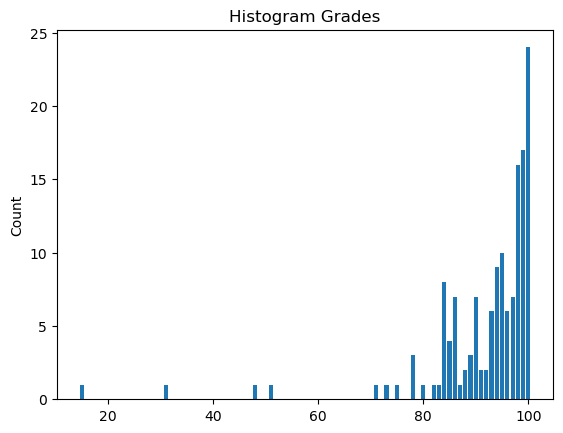

In [285]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

#### Finalizing the DataFrame and merging it with the questions_mapping_scores data.

In [286]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

C:\Users\sadiq\AppData\Local\Temp\ipykernel_24520\1505834086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "code"}, inplace=True)


,code,#user_prompts,prompt_avg_chars,response_avg_chars,similarity_score,keyword_occurrences,joy,anger,intelligence_scores
0,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.304163,113.633582,0.668851,46.0,0.081444,0.016167,0.279159
1,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.262324,17.187601,0.431948,64.0,0.083333,0.101556,0.245272
2,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.123346,107.092566,0.642125,23.0,0.094750,0.058200,0.204667
3,090d6217-5d69-4929-a342-19abab78324f,73.0,0.006570,26.744905,0.674966,110.0,0.054589,0.042712,0.232008
4,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.380935,186.805893,0.691306,43.0,0.089067,0.020867,0.293801


In [287]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,prompt_avg_chars,response_avg_chars,similarity_score,keyword_occurrences,joy,anger,intelligence_scores,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.304163,113.633582,0.668851,46.0,0.081444,0.016167,0.279159,0.168985,0.598951,0.724816,0.773233,0.580362,0.931004,0.700859,0.461774,0.615997
1,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.262324,17.187601,0.431948,64.0,0.083333,0.101556,0.245272,0.257655,0.255249,0.585046,0.312399,0.584948,0.425298,0.567792,0.524913,0.284810
2,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.123346,107.092566,0.642125,23.0,0.094750,0.058200,0.204667,0.173089,0.076724,0.244574,0.316824,0.384451,0.268569,0.220180,0.344579,0.539038
3,090d6217-5d69-4929-a342-19abab78324f,73.0,0.006570,26.744905,0.674966,110.0,0.054589,0.042712,0.232008,0.181944,0.551895,0.665395,0.723513,0.615884,0.778161,0.656450,0.527779,0.903510
4,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.380935,186.805893,0.691306,43.0,0.089067,0.020867,0.293801,0.322299,0.392534,0.533100,0.497379,0.673827,0.852372,0.755002,0.667692,0.554419


#### Merging scores with features

In [288]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df

,code,#user_prompts,prompt_avg_chars,response_avg_chars,similarity_score,keyword_occurrences,joy,anger,intelligence_scores,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.304163,113.633582,0.668851,46.0,0.081444,0.016167,0.279159,0.168985,0.598951,0.724816,0.773233,0.580362,0.931004,0.700859,0.461774,0.615997,99.0
1,041f950b-c013-409a-a642-cffff60b9d4b,9.0,0.262324,17.187601,0.431948,64.0,0.083333,0.101556,0.245272,0.257655,0.255249,0.585046,0.312399,0.584948,0.425298,0.567792,0.524913,0.284810,90.0
2,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.123346,107.092566,0.642125,23.0,0.094750,0.058200,0.204667,0.173089,0.076724,0.244574,0.316824,0.384451,0.268569,0.220180,0.344579,0.539038,97.0
3,090d6217-5d69-4929-a342-19abab78324f,73.0,0.006570,26.744905,0.674966,110.0,0.054589,0.042712,0.232008,0.181944,0.551895,0.665395,0.723513,0.615884,0.778161,0.656450,0.527779,0.903510,84.0
5,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,0.380935,186.805893,0.691306,43.0,0.089067,0.020867,0.293801,0.322299,0.392534,0.533100,0.497379,0.673827,0.852372,0.755002,0.667692,0.554419,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,ebe86296-3cae-429a-9a7c-aa8f21cfd7cb,21.0,0.476718,55.564560,0.572282,29.0,0.099905,0.048762,0.222962,0.154148,0.234426,0.288833,0.666853,0.253916,0.411438,0.280192,0.407284,0.582640,90.0
98,ef5b3fbc-f5d2-4446-bb4f-7d8b2a3026e9,100.0,0.057701,13.871465,0.519564,111.0,0.110480,0.034390,0.242500,0.205749,0.182756,0.271939,0.514262,0.598422,0.778161,0.676560,0.461774,0.609325,85.0
99,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,0.118153,131.912683,0.415467,26.0,0.098190,0.024190,0.185811,0.203477,0.166635,0.330979,0.230270,0.189311,0.509331,0.795576,0.782806,0.801861,93.0
100,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,0.105598,82.654365,0.259561,148.0,0.049300,0.035467,0.332239,0.212802,0.757185,0.859537,0.853645,0.726860,0.907903,0.726425,0.793183,0.565187,98.0


# Applying Upsampling and running the model.

#### Upsampling

In [289]:
# UPSAMPLES ALL CLASSES BY 4

import pandas as pd
from sklearn.utils import resample

# Assuming temp_df is your DataFrame and it contains a 'grade' column

# Initialize an empty DataFrame to hold the upsampled data
df_upsampled = pd.DataFrame()

# Iterate over each unique grade
for grade in temp_df['grade'].unique():
    # Filter the DataFrame for the current grade
    df_grade = temp_df[temp_df.grade == grade]
    
    # Determine the number of samples to upsample to (number of samples + 4)
    n_samples = df_grade.shape[0] + 4

    # Upsample the class for the current grade
    df_grade_upsampled = resample(df_grade, 
                                  replace=True,     # sample with replacement
                                  n_samples=n_samples,  # upsample by 4 samples
                                  random_state=123)  # reproducible results

    # Append the upsampled data to the combined DataFrame
    df_upsampled = pd.concat([df_upsampled, df_grade_upsampled])

# Shuffle the dataset to mix up the rows
df_upsampled = df_upsampled.sample(frac=1, random_state=123).reset_index(drop=True)



### Predicting and Analyzing with stratified K Fold and a hyperparameter-tuned Random Forest Regressor.

In [290]:
X = df_upsampled[temp_df.columns[1:-1]].to_numpy()
y = df_upsampled["grade"].to_numpy()
print(X.shape, y.shape)


(159, 17) (159,)


## 1. Random Forest Regression

### Hyperparameter Tuning for RandomForestRegressor Using GridSearchCV

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

# Define the parameters for GridSearch
param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt','log2'],
        'bootstrap': [True, False]
}

model = RandomForestRegressor()

# KFold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with KFold
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='r2')

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.8436428246556934


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error, r2_score

# Define the number of folds
n_folds = 5

# Initialize the StratifiedKFold object
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store scores
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R² score for both train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to the lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Print train and test set scores for each fold
    print("Fold:", len(train_mse_scores))
    print("Train MSE:", train_mse, "Test MSE:", test_mse)
    print("Train R²:", train_r2, "Test R²:", test_r2)


# Print the mean and standard deviation of the MSE and R² scores
print()
print("Mean Train MSE:", np.mean(train_mse_scores))
print("Standard Deviation of Train MSE:", np.std(train_mse_scores))
print("Mean Test MSE:", np.mean(test_mse_scores))
print("Standard Deviation of Test MSE:", np.std(test_mse_scores))
print("Mean Train R² score:", np.mean(train_r2_scores))
print("Standard Deviation of Train R² scores:", np.std(train_r2_scores))
print("Mean Test R² score:", np.mean(test_r2_scores))
print("Standard Deviation of Test R² scores:", np.std(test_r2_scores))


Fold: 1
Train MSE: 19.19839114453387 Test MSE: 28.60652738975766
Train R²: 0.3884553023140185 Test R²: 0.014846994894501142
Fold: 2
Train MSE: 19.239173832327477 Test MSE: 35.4811687171519
Train R²: 0.3626753953576094 Test R²: -0.05461522825968723
Fold: 3
Train MSE: 19.563148339053154 Test MSE: 27.652378660163798
Train R²: 0.3506949257393073 Test R²: 0.16099854115350554
Fold: 4
Train MSE: 20.679457725399203 Test MSE: 25.1633658639455
Train R²: 0.38043364381660283 Test R²: -0.18812458488712513
Fold: 5
Train MSE: 19.030808719039282 Test MSE: 29.417116655988934
Train R²: 0.3539829274782569 Test R²: 0.1783779980980097

Mean Train MSE: 19.542195952070596
Standard Deviation of Train MSE: 0.5941959940021807
Mean Test MSE: 29.26411145740156
Standard Deviation of Test MSE: 3.4211525952453345
Mean Train R² score: 0.36724843894115894
Standard Deviation of Train R² scores: 0.01479517490965124
Mean Test R² score: 0.0222967441998408
Standard Deviation of Test R² scores: 0.13700192137605452


## 2. Simple Linear Regression


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

model = LinearRegression()

# KFold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with KFold
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='r2')

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error, r2_score

# Define the number of folds
n_folds = 5

# Initialize the StratifiedKFold object
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store scores
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R² score for both train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to the lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Print train and test set scores for each fold
    print("Fold:", len(train_mse_scores))
    print("Train MSE:", train_mse, "Test MSE:", test_mse)
    print("Train R²:", train_r2, "Test R²:", test_r2)


# Print the mean and standard deviation of the MSE and R² scores
print()
print("Mean Train MSE:", np.mean(train_mse_scores))
print("Standard Deviation of Train MSE:", np.std(train_mse_scores))
print("Mean Test MSE:", np.mean(test_mse_scores))
print("Standard Deviation of Test MSE:", np.std(test_mse_scores))
print("Mean Train R² score:", np.mean(train_r2_scores))
print("Standard Deviation of Train R² scores:", np.std(train_r2_scores))
print("Mean Test R² score:", np.mean(test_r2_scores))
print("Standard Deviation of Test R² scores:", np.std(test_r2_scores))


Fold: 1
Train MSE: 19.19839114453387 Test MSE: 28.60652738975766
Train R²: 0.3884553023140185 Test R²: 0.014846994894501142
Fold: 2
Train MSE: 19.239173832327477 Test MSE: 35.4811687171519
Train R²: 0.3626753953576094 Test R²: -0.05461522825968723
Fold: 3
Train MSE: 19.563148339053154 Test MSE: 27.652378660163798
Train R²: 0.3506949257393073 Test R²: 0.16099854115350554
Fold: 4
Train MSE: 20.679457725399203 Test MSE: 25.1633658639455
Train R²: 0.38043364381660283 Test R²: -0.18812458488712513
Fold: 5
Train MSE: 19.030808719039282 Test MSE: 29.417116655988934
Train R²: 0.3539829274782569 Test R²: 0.1783779980980097

Mean Train MSE: 19.542195952070596
Standard Deviation of Train MSE: 0.5941959940021807
Mean Test MSE: 29.26411145740156
Standard Deviation of Test MSE: 3.4211525952453345
Mean Train R² score: 0.36724843894115894
Standard Deviation of Train R² scores: 0.01479517490965124
Mean Test R² score: 0.0222967441998408
Standard Deviation of Test R² scores: 0.13700192137605452


## 3. Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold


# Define the parameters for GridSearch
param_grid = {
    'alpha': [0.001, 0.1, 1, 10, 100]  # Regularization strength
}

model = Ridge()

# KFold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with KFold
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='r2')

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'alpha': 0.001}
Best Score: 0.0278578719597824


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the number of folds
n_folds = 5

# Initialize the StratifiedKFold object
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store scores
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Ridge()
    model.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R² score for both train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to the lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Print train and test set scores for each fold
    print("Fold:", len(train_mse_scores))
    print("Train MSE:", train_mse, "Test MSE:", test_mse)
    print("Train R²:", train_r2, "Test R²:", test_r2)


# Print the mean and standard deviation of the MSE and R² scores
print()
print("Mean Train MSE:", np.mean(train_mse_scores))
print("Standard Deviation of Train MSE:", np.std(train_mse_scores))
print("Mean Test MSE:", np.mean(test_mse_scores))
print("Standard Deviation of Test MSE:", np.std(test_mse_scores))
print("Mean Train R² score:", np.mean(train_r2_scores))
print("Standard Deviation of Train R² scores:", np.std(train_r2_scores))
print("Mean Test R² score:", np.mean(test_r2_scores))
print("Standard Deviation of Test R² scores:", np.std(test_r2_scores))


Fold: 1
Train MSE: 26.41459029581522 Test MSE: 24.436028601865658
Train R²: 0.15859081548337794 Test R²: 0.1584708384216147
Fold: 2
Train MSE: 23.352040058334076 Test MSE: 47.810506320482645
Train R²: 0.22643093578355755 Test R²: -0.42108306629743963
Fold: 3
Train MSE: 24.09596429828871 Test MSE: 36.974930308443064
Train R²: 0.20024979533327036 Test R²: -0.12185721347081535
Fold: 4
Train MSE: 27.472752171462492 Test MSE: 20.21578862865175
Train R²: 0.17690332197171066 Test R²: 0.045482404760589734
Fold: 5
Train MSE: 24.86787568458455 Test MSE: 32.45984245922514
Train R²: 0.15583869888210677 Test R²: 0.09339446640355276

Mean Train MSE: 25.24064450169701
Standard Deviation of Train MSE: 1.508411712996835
Mean Test MSE: 32.37941926373365
Standard Deviation of Test MSE: 9.69840195948941
Mean Train R² score: 0.18360271349080465
Standard Deviation of Train R² scores: 0.026655953760761297
Mean Test R² score: -0.04911851403649956
Standard Deviation of Test R² scores: 0.20784665944836195


## 4. Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold


# Define the parameters for GridSearch
param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000]  # Regularization strength
}
model = Lasso()

# KFold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with KFold
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='r2')

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'alpha': 100}
Best Score: -0.0205841050965871


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the number of folds
n_folds = 5

# Initialize the StratifiedKFold object
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store scores
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Lasso(**best_params)
    model.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R² score for both train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to the lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Print train and test set scores for each fold
    print("Fold:", len(train_mse_scores))
    print("Train MSE:", train_mse, "Test MSE:", test_mse)
    print("Train R²:", train_r2, "Test R²:", test_r2)


# Print the mean and standard deviation of the MSE and R² scores
print()
print("Mean Train MSE:", np.mean(train_mse_scores))
print("Standard Deviation of Train MSE:", np.std(train_mse_scores))
print("Mean Test MSE:", np.mean(test_mse_scores))
print("Standard Deviation of Test MSE:", np.std(test_mse_scores))
print("Mean Train R² score:", np.mean(train_r2_scores))
print("Standard Deviation of Train R² scores:", np.std(train_r2_scores))
print("Mean Test R² score:", np.mean(test_r2_scores))
print("Standard Deviation of Test R² scores:", np.std(test_r2_scores))


Fold: 1
Train MSE: 31.393275450148597 Test MSE: 29.131591540367253
Train R²: 0.0 Test R²: -0.0032351902934644183
Fold: 2
Train MSE: 30.187401666569546 Test MSE: 33.964113484945614
Train R²: 0.0 Test R²: -0.009523434278775333
Fold: 3
Train MSE: 30.12936309072898 Test MSE: 34.42511296756388
Train R²: 0.0 Test R²: -0.044493146708934006
Fold: 4
Train MSE: 33.377309014626185 Test MSE: 21.25118971310918
Train R²: 0.0 Test R²: -0.003405549669437402
Fold: 5
Train MSE: 29.458677685950413 Test MSE: 37.31689049586778
Train R²: 0.0 Test R²: -0.04226320453232435

Mean Train MSE: 30.909205381604743
Standard Deviation of Train MSE: 1.3826817835012453
Mean Test MSE: 31.217779640370743
Standard Deviation of Test MSE: 5.634067544004257
Mean Train R² score: 0.0
Standard Deviation of Train R² scores: 0.0
Mean Test R² score: -0.0205841050965871
Standard Deviation of Test R² scores: 0.018761938458033464


## 5. KNN Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold


# Define the parameters for GridSearch
param_grid = {
    'n_neighbors': [15, 20 , 25],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
}

model = KNeighborsRegressor()


# KFold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with KFold
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='r2', verbose=2)

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ....algorithm=auto, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ...algorithm=auto, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...algorithm=auto, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...algorithm=auto, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...algorithm=auto, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...algorithm=auto, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=20, weights=uniform; total time=   0.0s
[CV] END ....algorithm=auto, n_neighbors=20, we

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the number of folds
n_folds = 5

# Initialize the StratifiedKFold object
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store scores
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = KNeighborsRegressor(**best_params)
    model.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R² score for both train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to the lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Print train and test set scores for each fold
    print("Fold:", len(train_mse_scores))
    print("Train MSE:", train_mse, "Test MSE:", test_mse)
    print("Train R²:", train_r2, "Test R²:", test_r2)


# Print the mean and standard deviation of the MSE and R² scores
print()
print("Mean Train MSE:", np.mean(train_mse_scores))
print("Standard Deviation of Train MSE:", np.std(train_mse_scores))
print("Mean Test MSE:", np.mean(test_mse_scores))
print("Standard Deviation of Test MSE:", np.std(test_mse_scores))
print("Mean Train R² score:", np.mean(train_r2_scores))
print("Standard Deviation of Train R² scores:", np.std(train_r2_scores))
print("Mean Test R² score:", np.mean(test_r2_scores))
print("Standard Deviation of Test R² scores:", np.std(test_r2_scores))


Fold: 1
Train MSE: 0.0 Test MSE: 8.251669036752974
Train R²: 1.0 Test R²: 0.7158286135910445
Fold: 2
Train MSE: 0.0 Test MSE: 11.808689938423637
Train R²: 1.0 Test R²: 0.649007496507906
Fold: 3
Train MSE: 0.0 Test MSE: 5.559157743996259
Train R²: 1.0 Test R²: 0.8313294666440453
Fold: 4
Train MSE: 0.0 Test MSE: 7.086512089925283
Train R²: 1.0 Test R²: 0.6654001185428098
Fold: 5
Train MSE: 0.0 Test MSE: 5.680711989932078
Train R²: 1.0 Test R²: 0.8413373407061493

Mean Train MSE: 0.0
Standard Deviation of Train MSE: 0.0
Mean Test MSE: 7.677348159806047
Standard Deviation of Test MSE: 2.2899870416837653
Mean Train R² score: 1.0
Standard Deviation of Train R² scores: 0.0
Mean Test R² score: 0.7405806071983909
Standard Deviation of Test R² scores: 0.08128674738406311


## 6. Decision Tree Regressor

In [ ]:
from sklearn.neighbors import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold


# Define the parameters for GridSearch
param_grid = {
    'max_depth': [3, 5, 10, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

model = DecisionTreeRegressor()


# KFold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with KFold
grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='r2', verbose=2)

# Fit the model
grid_search.fit(X, y)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, min_samples_l

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Define the number of folds
n_folds = 5

# Initialize the StratifiedKFold object
skf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store scores
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = DecisionTreeRegressor(**best_params)
    model.fit(X_train, y_train)

    # Predict on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate MSE and R² score for both train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append scores to the lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Print train and test set scores for each fold
    print("Fold:", len(train_mse_scores))
    print("Train MSE:", train_mse, "Test MSE:", test_mse)
    print("Train R²:", train_r2, "Test R²:", test_r2)


# Print the mean and standard deviation of the MSE and R² scores
print()
print("Mean Train MSE:", np.mean(train_mse_scores))
print("Standard Deviation of Train MSE:", np.std(train_mse_scores))
print("Mean Test MSE:", np.mean(test_mse_scores))
print("Standard Deviation of Test MSE:", np.std(test_mse_scores))
print("Mean Train R² score:", np.mean(train_r2_scores))
print("Standard Deviation of Train R² scores:", np.std(train_r2_scores))
print("Mean Test R² score:", np.mean(test_r2_scores))
print("Standard Deviation of Test R² scores:", np.std(test_r2_scores))


Fold: 1
Train MSE: 0.0 Test MSE: 8.606060606060606
Train R²: 1.0 Test R²: 0.7036240591992917
Fold: 2
Train MSE: 0.0 Test MSE: 8.454545454545455
Train R²: 1.0 Test R²: 0.7487035318521753
Fold: 3
Train MSE: 0.0 Test MSE: 4.242424242424242
Train R²: 1.0 Test R²: 0.8712805081912404
Fold: 4
Train MSE: 0.12975557097694504 Test MSE: 6.6228806584362125
Train R²: 0.996112461585202 Test R²: 0.687291144769466
Fold: 5
Train MSE: 0.0 Test MSE: 14.25
Train R²: 1.0 Test R²: 0.6019965632926929

Mean Train MSE: 0.025951114195389008
Standard Deviation of Train MSE: 0.051902228390778016
Mean Test MSE: 8.435182192293302
Standard Deviation of Test MSE: 3.307728422372386
Mean Train R² score: 0.9992224923170404
Standard Deviation of Train R² scores: 0.0015550153659192212
Mean Test R² score: 0.7225791614609733
Standard Deviation of Test R² scores: 0.08824882577407554
